# Sampling

This notebook discusses sampling, from chapter 11 of Bishop's Pattern Recognition and Machine Learning.

Sampling from $Uniform[0, 1]$ is easy (using a pseudo-random number generator). Before we discuss complex distributions, we must bridge the gap -- how do we sample from simple (nonuniform) distributions?

Inverse transform sampling allows us to sample from a distribution through the following steps:
1) Take a nonuniform distribution $p(y) = p(z)\left|\frac{dz}{dy}\right|$ where $z$ is uniformly distributed on $[0, 1]$, and $y = f(z)$

2) Find the cumulative density function $z = h(y) = \int_{-\infty}^y p(\widehat{y})\text{d}\widehat{y}$ to get a function mapping $Dom(p(y)) \mapsto [0, 1]$

3) Invert the cumulative density function $y = h^{-1}(z)$ to get a function mapping $[0, 1] \mapsto Dom(p(y))$

4) Generate samples from Uniform[0, 1] and pass them through $h^{-1}(z)$, which will then be distributed according to $p(y)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

For example, let's take
$$p(y) = \lambda \exp(-\lambda y).$$
Here, the indefinite integral (whose lower limit is now 0 instead of $-\infty$) is
$$h(y) = 1-\exp(-\lambda y)$$
and then pass $z \sim Uniform[0, 1]$ through $h^{-1}$:
$$y = -\lambda^{-1}\ln(1-z)$$

In [25]:
p = lambda y, l: l*np.exp(-l*y)
h = lambda y, l: 1-np.exp(-l*y)
y = lambda z, l: -1/l * np.log(1-z)

/Users/kanyesthaker/Documents/projects/prml-notebooks/.env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Samples drawn from inverse transform'}, ylabel='Samples'>

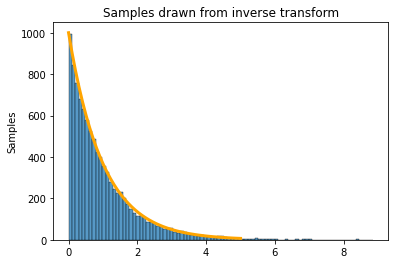

In [86]:
xs = np.linspace(0, 5)
ys = [p(x, 1) for x in xs]
zs = np.random.uniform(0, 1, 10000)
samples = [y(z, 1) for z in zs]
plt.ylabel("Samples")
plt.title("Samples drawn from inverse transform")
sns.lineplot(xs, [y*1000 for y in ys], color="orange", linewidth=3)
sns.histplot(data=sorted(samples), bins=90)

To sample from the Gaussian distribution, we use the Box-Muller method since the Gaussian inverse CDF is not well-defined. To do this, we uniformly select samples from a unit circle, after which we transform those samples (in polar form) to get our desired standard normal PDF.

<AxesSubplot:ylabel='Count'>

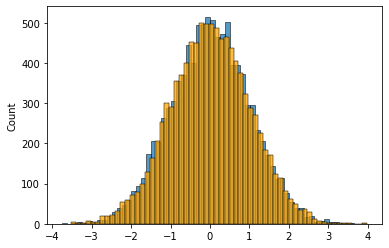

In [87]:
u1 = np.random.uniform(0, 1, 10000)
u2 = np.random.uniform(0, 1, 10000)
r2 = -2 * np.log(u1)
theta = 2 * np.pi * u2
z1 = np.sqrt(r2) * np.cos(theta)
z2 = np.sqrt(r2) * np.sin(theta)

sns.histplot(z1)
sns.histplot(z2, color="orange")